## HeartFailure data preprocessing

### Importing necessary libraries

In [1]:
import os
import sys
current_directory=os.getcwd()
parent_directory=os.path.dirname(current_directory)
sys.path.append(parent_directory)


In [2]:
import numpy as np
from library.generators.NextConvGeN import NextConvGeN


2024-01-31 11:58:54.234651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-31 11:58:54.234669: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
from fdc.clustering import *

In [4]:
import pandas as pd

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Importing data

In [6]:
data=pd.read_csv('diabetes.csv')

In [7]:
np.random.seed(42)
data=data.sample(frac=1)

In [8]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [9]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/PimaIndianDiabetes.csv")
data.to_csv(output_file_path, index=False)

In [10]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [11]:
data.drop(['Outcome'],axis=1, inplace=True)

In [12]:
np.random.seed(42)
data=data.sample(frac=1)

### UMAP on entire data

In [13]:
from fdc.fdc import feature_clustering

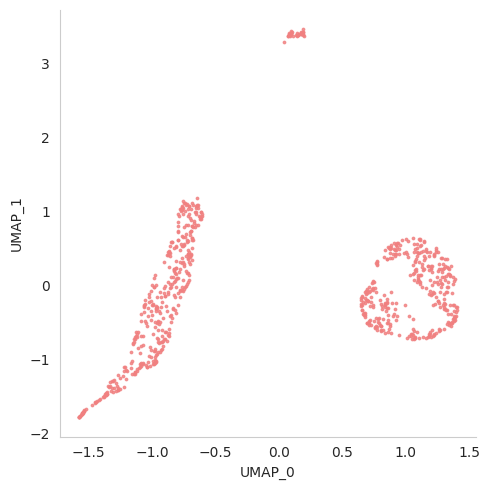

In [14]:
np.random.seed(42)
umap_emb=feature_clustering(30,0.1,'euclidean',data,True)

### Feature-type Distributed Clustering (FDC)

In [15]:
cont_list=[ 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

nom_list=None

ord_list=['Pregnancies']

target = ['Outcome']


In [16]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/PimaIndianDiabetes.json")

In [17]:
import json

features = {
    "cont_list": cont_list,
    "nom_list": nom_list,
    "ord_list": ord_list,
    "target": target
}

with open(output_file_path, "w") as json_file:
    json.dump(features, json_file)

FDC.normalize (init): 0.00001 / 0.000s


FDC.normalize (clustering CONT): 3.34943 / 3.349s


FDC.normalize (clustering ORD): 5.95778 / 9.307s
FDC.normalize (clustering NOM): 0.00005 / 9.307s
FDC.normalize (concat): 0.00002 / 9.307s


FDC.normalize (umap 5 -> 2): 2.25400 / 11.561s
FDC.normalize (array -> DataFrame): 0.00026 / 11.562s


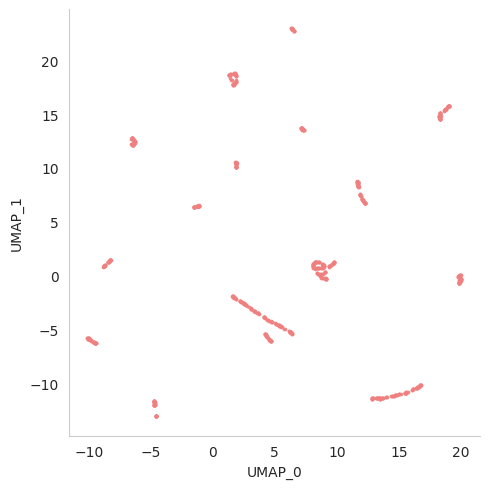

FDC.normalize (plotting): 0.40732 / 11.969s
FDC.normalize (array -> DataFrame): 0.00018 / 11.969s
FDC.normalize (total): 0.00001 / 11.969s


In [18]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
np.random.seed(42)

fdc = FDC(clustering_cont=Clustering('euclidean',30,0.01)
          , clustering_ord=Clustering(canberra_modified,30,0.01)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,cont_list=cont_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

### Clustering using K-means

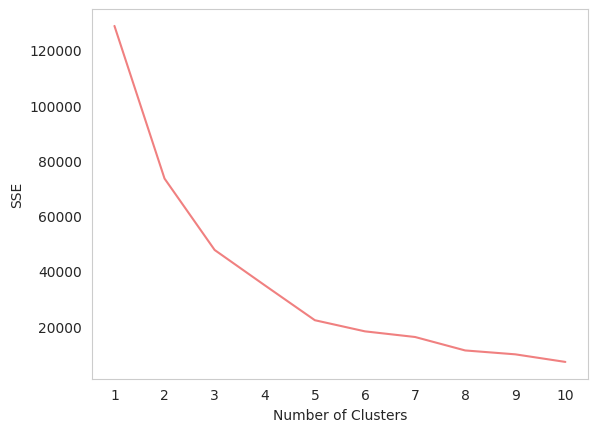

In [19]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(FDC_emb_low)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [20]:
def find_optimal_cluster(FDC_emb_low):
    silhouette_scores = []

    for n_clusters in list(range(2, 9)):
        km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)

        km.fit(FDC_emb_low)

        labels = km.labels_

        # Compute the silhouette score
        silhouette_avg = silhouette_score(FDC_emb_low, labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [21]:
find_optimal_cluster(FDC_emb_low)

[0.41994658,
 0.46044818,
 0.48790172,
 0.5526744,
 0.57846457,
 0.63166255,
 0.64932984]

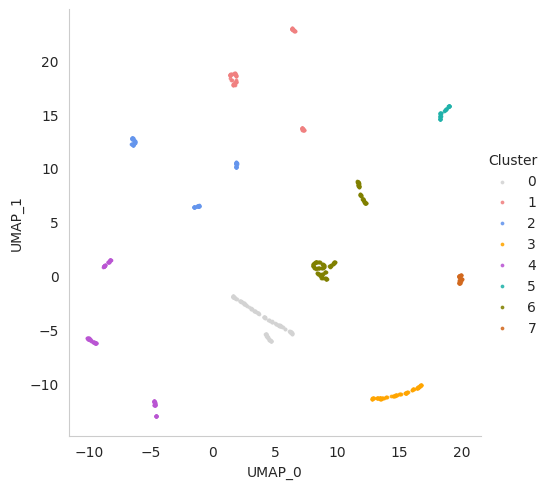

In [22]:
from fdc.clustering import *
np.random.seed(42)
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(8)

In [23]:
cluster_counts

array([133,  95,  94,  92, 107,  45, 160,  42])

In [24]:
data['Target']=cluster_list

In [25]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/SSPimaIndianDiabetes.csv")
data.to_csv(output_file_path, index=False)

In [26]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Target
668,0,129,80,0,0,31.2,0.703,29,5
324,2,108,80,0,0,27.0,0.259,52,4
624,3,139,54,0,0,25.6,0.402,22,2
690,2,146,0,0,0,27.5,0.240,28,4
473,6,134,70,23,130,35.4,0.542,29,6
...,...,...,...,...,...,...,...,...,...
71,4,83,86,19,0,29.3,0.317,34,4
106,2,141,58,34,128,25.4,0.699,24,0
270,4,90,0,0,0,28.0,0.610,31,4
435,7,97,76,32,91,40.9,0.871,32,6
